<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab09_hmm2/viterbi_ex1.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 

# Viterbi Alignment - Exercise 1

In this Exercise we compute the Viterbi Alignment of real speech examples.
We use the Viterbi algorithm to distinguish between differen pronunciation options

In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
import torch
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]
pd.set_option("display.precision", 3)

# pyspch
import pyspch
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm
from pyspch.stats import GMM, Prob
import pyspch.nn

# device
torch.manual_seed(0)
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

from pyspch.core.utils_x import plot_probs, get_test_file

In [4]:
### SOME UTILITIES
######################

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

def make_vit_graph(phn_seq,phn_set,l2r=1.0,eps=0.0,skip=0.0,extra_arcs=None):
    ''' 
    Makes an HMM Graph with Viterbi Alignment as main purpose
    The graph starts from a canonical phone sequence (phn_seq) that is arranged in a Left-2-Right fashion.
    Then additional arcs can be added to allow for deviating pronunciations.
    It is assumed (given the Viterbi purpose) that the graph is entered in the first phone and exits in the last phone

    This module returns not a graph as such but the parameters defining the HMM state/transition model

    Parameters:
    ===========
        - phn_seq     canonical phone sequence (list)
        - phn_set     the complete phone set known to the HMM acoustic model (set)
        - l2r         transition probability of the l2r arcs (float) 
        - eps         probability that can be assigned to all NON L2R arcs (float, default=0.0)
        - skip        probability assigned to all arcs that make a single skip in the canonical phone sequence (float, default=0.0)
        - extra_arcs  additional arcs that can be added to the graph (list of [start,end] nodes; start & end are indexes in the canonical sequence)
        
    Returns:
    ========
        - obs_indx    points to the index of the observation probability function (list of length len(phn_seq))
        - trans_mat   HMM transition matrix derived from the graph
        - init_mat    HMM init matrix
        - end_states  HMM admissible end states

        DISCLAIMER: The probability matrices are floats that are all less than 1.0 (making them suitable for the HMM package) 
                    but extra normalization is required to turn them into true probabilities
                    
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_seq = len(phn_seq)
    obs_indx = np.zeros(n_seq,dtype='int')
    trans_mat = np.eye(n_seq,dtype='float32')

    for i  in range(n_seq): 
        obs_indx[i] = phn2idx[phn_seq[i]]

    # This code assumes the graph is constructed for Viterbi 
    init_mat = np.zeros(n_seq,dtype='float32')
    init_mat[0] = 1.0
    end_states = np.array([n_seq-1])
    # add left-to-right arcs
    for i in range(n_seq-1):
        trans_mat[i,i+1] = np.maximum(l2r,trans_mat[i,i+1])
        if i+2 < n_seq:
            trans_mat[i,i+2] = np.maximum(eps,skip)
                

    # add extra arcs with the same transition probability as the LR arcs
    if extra_arcs is not None:
        for arc in extra_arcs:
            (i,j) =  arc[0],arc[1]
            trans_mat[i,j] = np.maximum(l2r,trans_mat[i,j])
        
    # set eps probabilities on all 'other' arcs
    trans_mat = np.maximum(eps,trans_mat)
    init_mat = np.maximum(eps,init_mat)
     
    return(obs_indx,trans_mat,init_mat,end_states)

def make_graph2(states,transitions=None,init=None,end=None):
    ''' 
    makes an HMM Graph over a set of states
    - states: list of defined states (required)
    - transitions: REQUIRED
    - init: list of allowed initial states (default=None=ALL)
    - end: list of allowed end states (default=None=ALL)

    Returns:
    - obs_indx:   indices of used states (referencing to state collection for observation model computations)
    - trans_mat:  transition matrix
    - init_mat:   initial matrix
    - end_states: end states (indices in HMM graph)
    
    '''
    state2idx = {lab: i for i, lab in enumerate(states)}

    if transitions is None:
        print("transitions must be specified")
        return(-1)
    n_trans = len(transitions)
    trans_ar = np.asarray(transitions)
    
    used_states = []
    for tr in transitions:
        for S in tr:
            if S not in used_states: used_states.append(S)
    n_used = len(used_states)
    used2idx = {lab: i for i, lab in enumerate(used_states)}
    
    obs_indx = np.zeros(n_used,dtype='int')
    for i  in range(n_used): 
        obs_indx[i] = state2idx[used_states[i]]
    
    if init is None: init = used_states
    init_mat = np.zeros(n_used,dtype='float32')
    for state in init:
        init_mat[ used2idx[state] ] = 1.0    

    if end is None: end = used_states
    end_states = np.asarray([ used2idx[state] for state in end ])

    # initialize transition matrix with self-loops
    trans_mat = np.eye(n_used,dtype='float32')    
    for tr in transitions:
        trans_mat[ used2idx[tr[0]], used2idx[tr[1]] ] = 1.0
           
    return(obs_indx,trans_mat,init_mat,end_states)

In [5]:
# lexicon utilities
lexicon = {
    'sil':['sil'],
    'the': ['dh','ah'],
    'reasons': ['r','iy','z','ah','n','z'],
    'for': ['f','ao', 'r'],
    'this': ['dh','ih','s'],
    'dive': ['dh','ay','v'],
    'seemed': ['s','iy','m','d'],
    'foolish': ['f','uw','l','ih','sh'],
    'now': ['n','aw'],
    'by' : ['b','ay'], 
    'that' : ['dh','ae','t'],
    'time' : ['t','ay','m'],
    'perhaps': ['p','er','hh','ae','p','s'],
    'something': ['s','ah','m','th','iy','ng'],
    'better': ['b','eh','t','er'],
    'can': ['k','ae','n'],
    'be': ['b','iy'],
    'done': ['d','ah','n'],
    'bricks': ['b','r','ih','k','s'],
    'are': ['aa','r'],
    'an': ['ae','n'],
    'alternative':['ao','l','t','er','n','ah','t','ih','v'],
    'eating':['iy','t','ih','ng'],
    'spinach':['s','p','ih','n','ah','ch'],
    'nightly':['n','ay','t','l','iy'],
    'increases':['ih','n','k','r','iy','z','ah','z'],
    'strength':['s','t','r','eh','ng','k','th'],
    'miraculously':['m','er','ae','k','y','ah','l','ah','s','l','iy'],
    'they':['dh','ey'],
    'also':['ao','l','s','ow'],
    'want':['w','aa','n','t'],
    'money':['m','ah','n','iy'],
    'prestige':['p','r','eh','s','t','iy','zh'],
    'and':['ah','n','d'],
    'security':['s','ih','k','y','uh','r','ah','t','iy'],
    'friendly':['f','r','eh','n','d','l','iy'],
    'computers':['k','ah','m','p','y','uw','t','er','z'],
    'two':['t','uw'],
    'nine':['n','ay','n'],
    'five':['f','ay','v'],
    'seven':['s','eh','v','ah','n']
}

def wrds_2_phns(wrds,lexicon,glue=None,CLEANUP=True):
    '''
    expand list of words (wrds) to list of phones with glue symbol in between
    CLEANUP=True eliminates duplicate successive symbols
    '''
    if glue is None:
        phns = []
    else :
        phns = [glue]
    for wrd in wrds:
        for phn in lexicon[wrd]:
            phns.append(phn)
        if glue is not None: phns.append(glue)
    if CLEANUP:
        prev = ""
        clean_phns = []
        for phn in phns:
            if phn != prev:
                clean_phns.append(phn)
                prev = phn
        return(clean_phns)
    else:
        return(phns)

def make_bplabels(backptrs,labels,values=None):
    (N,M) = backptrs.shape
    bplabels = np.full((N,M),"",dtype="<U6")

    for i in range(N):
        for j in range(M):
            if backptrs[i,j] !=-1:
                if values is None:
                    bplabels[i,j] = labels[ backptrs[i,j] ]
                else:
                    bplabels[i,j] = f"{values[i,j]:.{0}f}" + " " +   labels[ backptrs[i,j] ]               
    return(bplabels)

## 1. Load Trained Acoustic Models

You can use 2 pretrained models trained on the TIMIT database.  They both use MFCC cepstral features and have models trained for phoneme classification (i.e. single state phonemes)

1. **GMM Model**
- Feature Extraction:  MFCC26=  MFCC13 + Deltas + mean-variance normalization
- model: S41_D26_G64_FULL_1.pkl  G64=64 Gaussians, S41= 41 classes/states, D26 = 26 dim features, (FrameRecog: 56%)

2. **DNN Model**
- Feature Extraction: MFCC39:  MFCC13 + Deltas + Delta_Deltas + mean-variance normalization
- splicing of 11 frames with stride 2  (receptive field of over 200 msec)
- model: an MLP with 3 hidden layers of size 429(IN) x 1024(H1) x 768(H2) x 512(H3) x 41(OUT)

In [6]:
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/'
timit_root = root_url + 'timit/'
#
# MFCC feature extraction: MFCC13 + delta's + delta_delta's mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta_delta2',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#
gmm_root = timit_root+'models/gmm/'
gmm_model = Spch.load_data("S41_D26_G64_FULL_1.pkl",root=gmm_root)  # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
gmm_nftrs = 26  # The GMMs use only the first 26 features (MFCCs + Deltas)
phn_set= gmm_model.classes
phn2idx = {lab: i for i, lab in enumerate(phn_set)}

In [7]:
# Some extra utilities for the DNN Model
# including an sklearn style wrapper around our torch DNN models 
# WARNING -- BE CAREFULL when combining long span receptive field in the DNNs with libhmm !! 
#    the DNN utilizes splicing and expects to see a stream of feature vectors to preform the splicing on
#    the calls will give good results for long sequences
#    this is NOT intended for frame by frame input and hence extra care is needed when combining with the libhmm library used below
#       the above problem is avoided by computing ALL observation_probs in one shot with this model before starting the trellis computations

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class DNN_model():
    def __init__(self,priors=None,setup=None,model=None,device="cpu"):
        self.prob_style = "Posteriors"
        self.class_prior_ = priors
        self.setup = setup
        self.model = model
        self.device = device
        
    def predict_proba(self,X):
        # X comes in as [n_samples, n_features], but splice_frames asssumes [n_features,n_samples]
        X_dnn = pyspch.sp.splice_frames(X.T,self.setup.sampler_args['N'], self.setup.sampler_args['stride'])
        # posteriors 
        X_t = torch.tensor(X_dnn).T.float().to(self.device)
        yp_t = self.model(X_t) # log probs
        yp_t = torch.nn.Softmax(dim=1)(yp_t) # probs
        proba = yp_t.cpu().detach().numpy()
        return(proba)
        
    def predict_prob(self,X):
        proba = self.predict_proba(X)
        if self.class_prior_ is None: probs = proba
        else:
            probs = proba / self.class_prior_
            probs = probs / np.sum(probs,axis=1,keepdims=True)
        return ( probs )
        
    def predict_log_prob(self,X):
        Xp = self.predict_prob(X)
        return ( Spch.logf( Xp ) ) 

def proba_2_prob(proba,priors=None):
    ''' compute normalized likelihoods (sum = 1) from posterior probabilities
    '''
    if priors is None: return(proba)
    else:
        probs = proba / priors
        probs = probs / np.sum(probs,axis=1,keepdims=True)
    return ( probs )

##############################################################################################
#
# load an existing DNN model
#
model_path = 'models/default/mfcc13dd2mv/N5s2/'  
model_fobj = pyspch.read_fobj(timit_root + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
# readout for one-hot encoding 
idx2lab = {v: k for k, v in lab2idx.items()}
    
setup = dotdict(setup)
model.to(device);

# the phone class priors are available in the GMM model and can be used here to convert posteriors to scaled likelihoods
# and be used with the DNN to convert from posteriors to (normalized) likelihoods 
dnn_model = DNN_model(setup=setup, model=model, priors= gmm_model.class_prior_, device=device)    
dnn_nftrs = 39

## 2. Define Your Setup

The next cell defines your setup where you need to can a number of choices
1. Choose which type of acoustic model
2. Choose the file input   (make a choice between: demo/friendly, misc/bad_bead_booded, timit0, timit1, ... timit4, digits/5752 )
       For this list of input files, specific 'highlights' have been specified for demo purposes
       For other files, the highlight times are by default 
4. Choose either the full file or a short segment

The cell after that will do all the required data loading

In [34]:
USE_DNN = True               # Use DNN if True, otherwise GMM
file_id = "demo/friendly"    # "demo/friendly"
#file_id = "timit1"
USE_SELECTION = True         # Highlight a fragment of the full utterance
# !! REMEMBER TO SPECIFY YOUR USE CASE (Manual, Canonical, ... ) at the start of SECTION 3. Viterbi Alignment

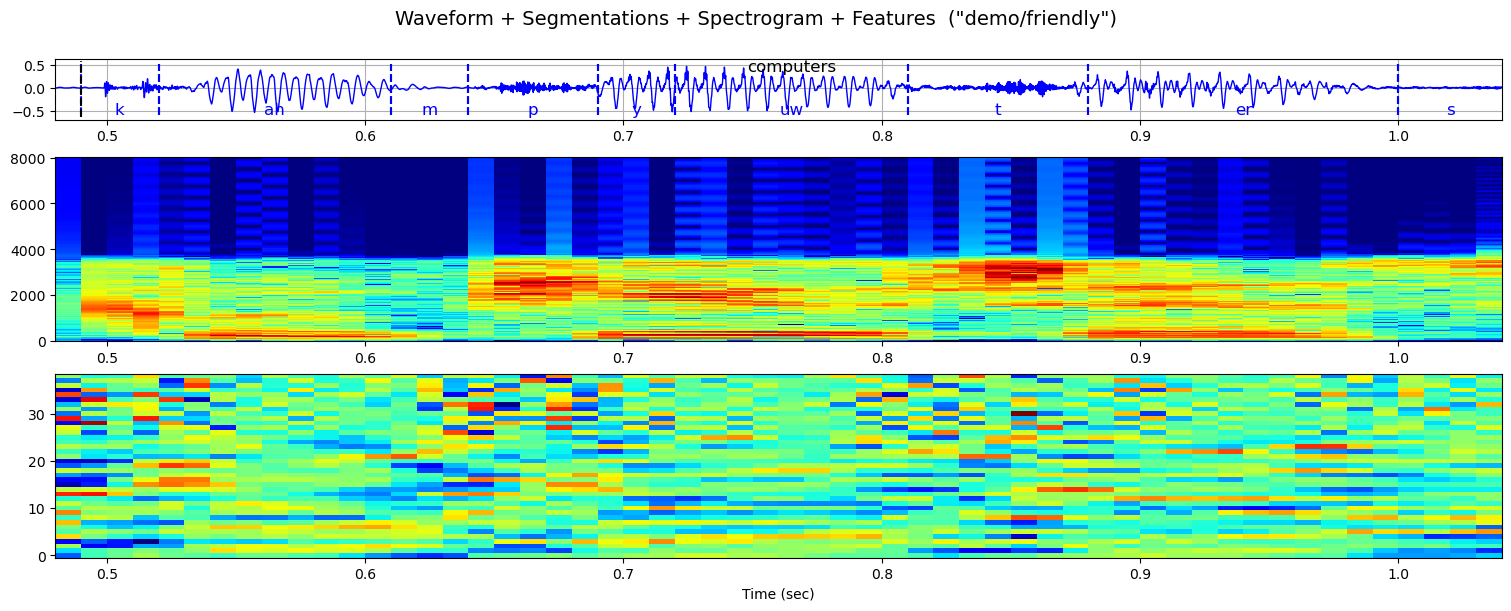

In [35]:
####################
#1. Model Selection
####################
if USE_DNN:
    acoustic_model = dnn_model
    nftrs = dnn_nftrs
else:
    acoustic_model = gmm_model
    nftrs = gmm_nftrs

####################
#2.a File Selection
####################
if file_id == 'demo/friendly':
    selection_times = np.array([0.48,1.04])
    canonical = ['sil','k',]       
elif file_id == 'misc/bad_bead_booed':
    selection_times = np.array([1.5,2.1])    
elif file_id == 'digits/5752':
    selection_times = np.array([0.,1.0])
elif file_id[:-1] == 'timit':
    no = int(file_id[5])
    timit_selection_times = [ [2.10,3.07], [.12,.82], [.05,.46], [1.96,2.7], [1.92,2.62] , [0.,1.], [0.,1.], [0.,1.] ] 
    selection_times = np.array(timit_selection_times[no])
else:
    print("Warning: file_id not recognized; default values used for selection highlighting")
    selection_times = np.array([0.5,1.0])

#######################################################
# 2.b Load file, transcripts and compute MFCC features
#######################################################
# load the full sentence data into the variables with a '1' at the end 
wavdata, sr, spgdata, ftrs, txt, seg_wrd, seg_phn = get_test_file(file_id,feature_args=feature_args)


delta_f = (sr/2)/(spgdata.shape[0]-1)
shift=feature_args['f_shift']
# only keep the required features for the model
ftrs=ftrs[:nftrs,:]
n_frames = ftrs.shape[1]
#
transcript = seg_phn['seg'].tolist()
labels = pyspch.seg2lbls(seg_phn, n_frames=n_frames,pad_lbl='sil')

###########################################################################
# 2.c Select a short fragment from the full sentence for the demo/exercise
##########################################################################
# make a selection of a short fragment into the variables ending in '2' 
# making  a selection is done for visualization purposes to restrict to max +- 100 frames and +- 15 phonemes in the plots
# you can override the segment selection times as in the following line
# selection_times = np.array([0.51,.92])
if USE_SELECTION:
    selection_times = selection_times
else:
    selection_times = np.array([0.,float(len(wavdata)-1)/float(sr)])
                       
frames= (selection_times* (1./shift) ).astype('int')
samples = (selection_times*sr).astype('int')
sample_slice = slice(samples[0],samples[1],1)
frame_slice = slice(frames[0],frames[1],1)
n_frames = frames[1]-frames[0]
time_ax = np.arange(frames[0],frames[1])*shift+0.5*shift
times = selection_times

################
################
#wavdata2 = wavdata1[sample_sel]
#spgdata2 = spgdata1[:,frame_slice]
#ftrs2 = ftrs1[:,frame_slice]
#
seg_phn2 = seg_phn[(seg_phn['t0']<(frames[1]-1)*shift) & (seg_phn['t1']>(frames[0]+1)*shift)].reset_index(drop=True)
seg_phn2['t0'] = seg_phn2['t0']-selection_times[0]
seg_phn2['t1'] = seg_phn2['t1']-selection_times[0]
seg_phn2['t0'][0]= 0.0
seg_wrd2 = seg_wrd[(seg_wrd['t0']<(frames[1]-4)*shift) & (seg_wrd['t1']>(frames[0]+4)*shift)].reset_index(drop=True)
seg_wrd2['t0'] = seg_wrd2['t0']-selection_times[0]
seg_wrd2['t1'] = seg_wrd2['t1']-selection_times[0]
seg_wrd2['t0'][0]= 0.0
#
transcript2 = seg_phn2['seg'].tolist()
#labels2 = pyspch.seg2lbls(seg_phn2, n_frames=ftrs2.shape[1],pad_lbl='sil')

###################################################################################
#  3. Use either selection data or the full sentence data based on global settings
###################################################################################
#if USE_SELECTION:
    #wavdata, spgdata, ftrs, labels, seg_phn, seg_wrd, transcript = wavdata2, spgdata2, ftrs2, labels2, seg_phn2, seg_wrd2, transcript2
#else:
    #wavdata, spgdata, ftrs, labels, seg_phn, seg_wrd, transcript = wavdata1, spgdata1, ftrs1, labels1, seg_phn1, seg_wrd1, transcript1

# define time axis for a frame indices


#################################################################################################
# 4. SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=delta_f,frames=frames,
                                  sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])
fig.add_seg_plot(seg_phn, iax=0, ypos=.1, color='b',size=12) 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='k',size=12)
fig.suptitle("Waveform + Segmentations + Spectrogram + Features  (\"%s\")\n" %(file_id),size=14)
display(fig)
display(Audio(data=wavdata,rate=sr))

### Frame Recognition

In frame recognition each feature vector is treated independently.  It consists of 2 simple steps:   
1. compute the class probabilities for each given feature vector
2. recognize by finding the maximum amongst all classes

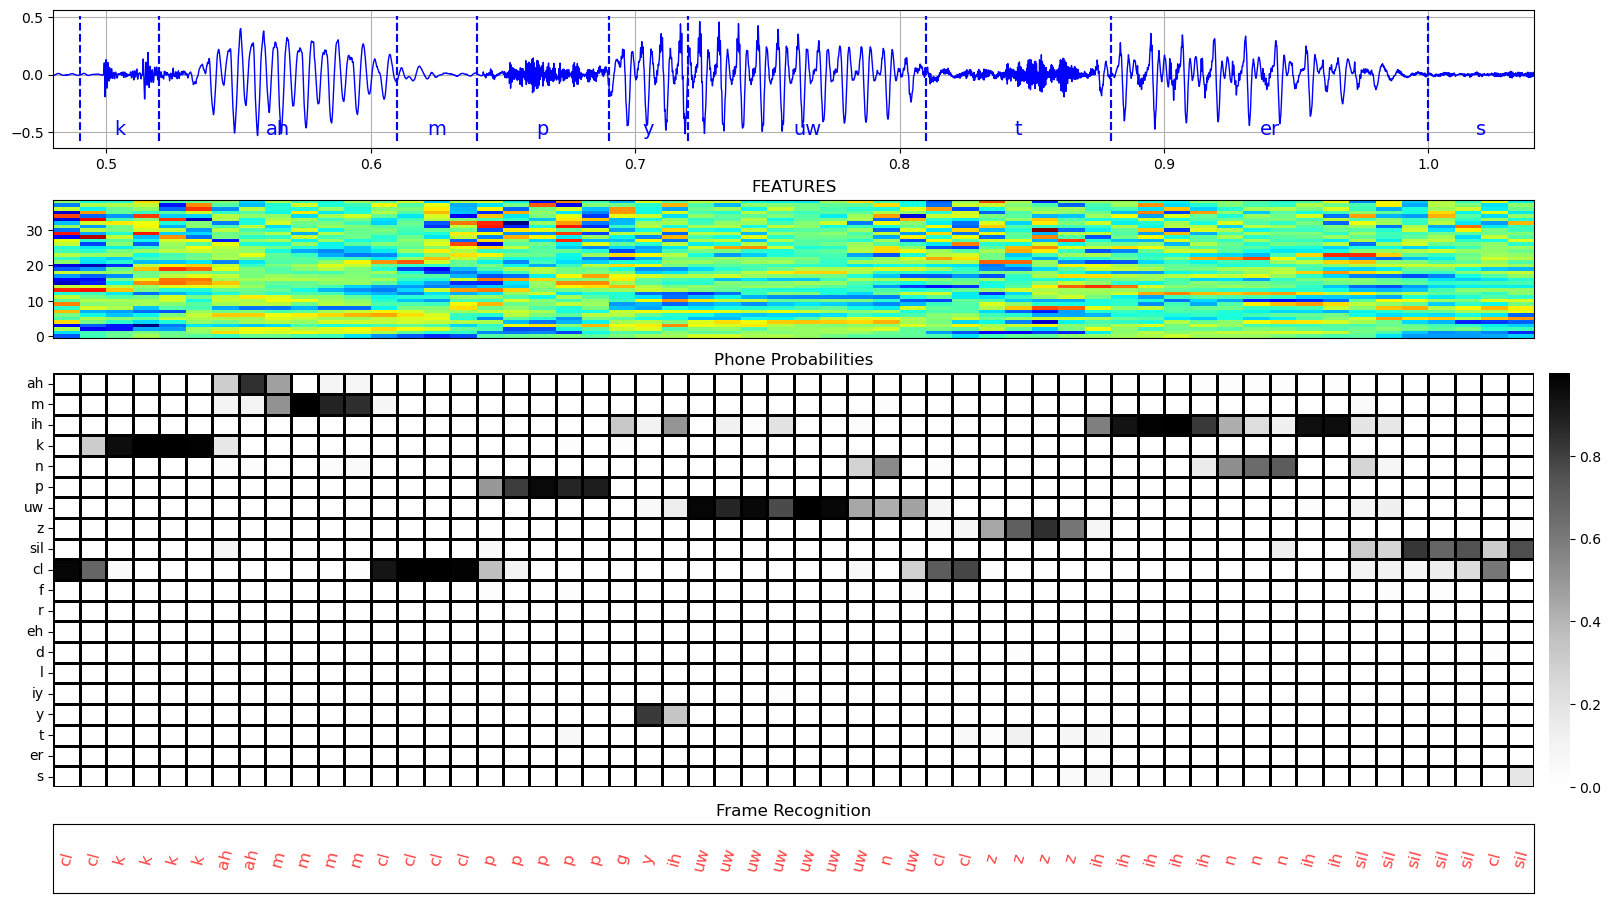

Frame Recognition Rate(18/56): 32.14 %


In [10]:
# 1. Compute Frame Based Posteriors
frame_proba = acoustic_model.predict_proba(ftrs.T)

# 2. Frame Recognition = Find the maximum amongst the classes
y_frame_idx = np.argmax(frame_proba[frame_slice,:], axis=1)
y_frame_lab = [phn_set[i] for i in y_frame_idx]
y_frame_ldf = pd.DataFrame({'t':time_ax,'lbl':y_frame_lab})

# 3. Measure Recognition Rate
n_corr = np.sum([y_frame_lab[i] == labels[i+frames[0]] for i in range(n_frames) ])

# 4. Illustrate: show the outputs of the most likely phones and at least all phones in the transcript, resorted for order in alphabet
top_k = 10
indx_sel = np.argsort(np.sum(frame_proba[frame_slice,:],axis=0))[::-1][0:top_k]
indx_sel = np.sort(indx_sel)
phn_sel = [phn_set[i] for  i in indx_sel]
phn_sel,indx_sel = select_phones_idx((phn_sel,transcript),phn_set,SORTED=False)
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,.5],frames=frames,
            sample_rate=sr, figsize=(16,9),  img_ftrs=[None,None],img_labels=[None,None])

(iax_wav, iax_ftr, iax_prob, iax_frame) = (0,1,2,3)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='b',size=14) 
fig.axes[iax_ftr].set_title("FEATURES")
fig.axes[iax_ftr].set_xticks([])
plot_probs(frame_proba[frame_slice,indx_sel], phn_sel,fig=fig, cmap='Greys',iax=iax_prob, style="img",title="Phone Probabilities") 
fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#F44',size=12,txtargs={'rotation':75},title="Frame Recognition")

fig.axes[iax_frame].set_xticks([])
fig.axes[iax_frame].set_xlabel("")
display(fig)

print("Frame Recognition Rate(%d/%d): %.2f %%" % (n_corr,n_frames,100.*n_corr/n_frames ) )

## 3. Viterbi Alignment
With a Viterbi Alignment we can align a given observation stream (feature vectors) against an HMM graph consisting of states (phones) and arcs (describing the possible transitions).
For the computations we use a TRELLIS, i.e. a matrix with time (observations) on the x-axis and HMM states on the y-axis.    
Each cell in a trellis contains the likelihood to be in a state 'S' at a given time 't' given the observation stream up to time 't.

When the exact transcription is known then the HMM graph takes the form of a strict left-to-right arrangement of HMM states . 

The graph may of course also be constructed to accept  multiple words / sentences / pronunciations ... correponding to any speech recognition problem.
A trellis is a good and efficient way to organize computations for small and moderate sized problems that we deal with here.  

### Computations
The computations involve following steps:   
1. compute the observation probabilities for each state given the feature vector (we compute the likelihoods indirectly from the probabilities used for frame recognition)
2. fill the trellis from left-to-right
3. Finalize: at the end of the observation stream you select the state with the highest likelihood to indicate the ending state.  However, you should only consider states that are ADMISSIBLE ending states (this is part of your graph definition)
4. Find the Viterbi alignment by backtracking on the trellis


### Use Cases

Different Use Cases have been predefined:   
STYLE = "MANUAL"       use the manual transcript as reference   
STYLE = "CANONICAL"    use the canonical transcript as reference   
STYLE = "CANONICAL1"   same as CANONICAL but with   
STYLE = "EX1", ..       a number of very specific use cases   

These can further be refined with additional flags   
- ADD_CL           will add a closure state before plosives  
- ADD_SIL_BETWEEN  will add a silence state between words   
- SKIP :           will allow skipping of states in the transcript    , or give a float number to specify the skip transition probs   
- ADD_SIL_END : will add a silence state at both ends of the transcript    


In [20]:
transcript

['f',
 'r',
 'eh',
 'n',
 'd',
 'l',
 'iy',
 'sil',
 'k',
 'ah',
 'm',
 'p',
 'y',
 'uw',
 't',
 'er',
 's']

In [44]:
# Viterbi for a number of different use cases
STYLE = "MANUAL"
#STYLE="CANONICAL"
#STYLE = "EX2"
SKIP = False
ADD_CL = False
ADD_SIL_END = False
ADD_SIL_BETWEEN = True
extra_arcs = None

if STYLE == "MANUAL":  # Strictly align against an available MANUAL transcription
    REF = "MANUAL"
elif STYLE == "CANONICAL": # Loosely align against a canonical trancriptions allowing for skips 
    REF = "CANONICAL"
elif STYLE == "CANONICAL1": # Loosely align against a canonical trancriptions allowing for skips 
    REF = "CANONICAL"
    SKIP = .1
elif STYLE == "EX1": # recognize between COMPUTE, COMPUTER and COMPUTERS 
    REF = ["sil","k","ah","m", "p","y","uw","t","eh","r","s" ,"sil" ] 
    extra_arcs = [[7,11], [9,11] ]
elif STYLE == "EX2": # recognize between COMPUTE, COMPUTER and COMPUTERS 
    REF = ["sil","k","ah","m", "p","y","uw","t","er","s" ,"sil" ] 
    extra_arcs = [[7,10], [8,10] ]

if SKIP is False: skip = 0.0
else: skip = SKIP
glue =  'sil' if ADD_SIL_BETWEEN else None
if REF == "MANUAL":  phone_seq = transcript2
elif REF == "CANONICAL": phone_seq = wrds_2_phns(seg_wrd2['seg'],lexicon=lexicon, glue=glue)
else: phone_seq = REF
# add closure state in front of every plosive
if ADD_CL and (REF!="MANUAL"):
    new_states = []
    for s in phone_seq:
        if s in ['p','t','k','b','d','g']: new_states.append('cl')
        new_states.append(s)
    phone_seq = new_states
# add silence at beginning and end
if ADD_SIL_END:
    phone_seq = ['sil'] + phone_seq + ['sil']
#print(phone_seq)    
obs_indx, trans_mat,init_mat,end_states = make_vit_graph(phone_seq,phn_set,l2r=1.0,skip=skip,extra_arcs=extra_arcs)

In [45]:
# HMMs work with "observation" likelihoods that can be computed (up to a scaling factor) from the posterior probabilities 
# For scaling/numerical purposes we do all computations with log-likelihoods / log-probabilities
frame_lik = proba_2_prob(frame_proba[frame_slice,:],priors=gmm_model.class_prior_)
log_lik = Spch.logf(frame_lik)
hmm1 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=None,states=phone_seq,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# we constructed the HMM graph with 'linear' probabilities, now we convert everything to log-probs
hmm1.set_probstyle('log')
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(log_lik)
# recognize from the trellis
y_vit_lbl = hmm1.states[trellis1.backtrace()]
y_vit_ldf = pd.DataFrame({'t':time_ax,'lbl':y_vit_lbl})
y_vit_seg = Spch.lbls2seg(y_vit_lbl,start_time=times[0])
n_corr = np.sum([y_vit_lbl[i] == labels[i+frames[0]] for i in range(len(y_vit_lbl))])
print("Frame level agreement with manual alignment(%d/%d): %.2f %%" % (n_corr,n_frames,100.*n_corr/n_frames) )

Frame level agreement with manual alignment(38/56): 67.86 %


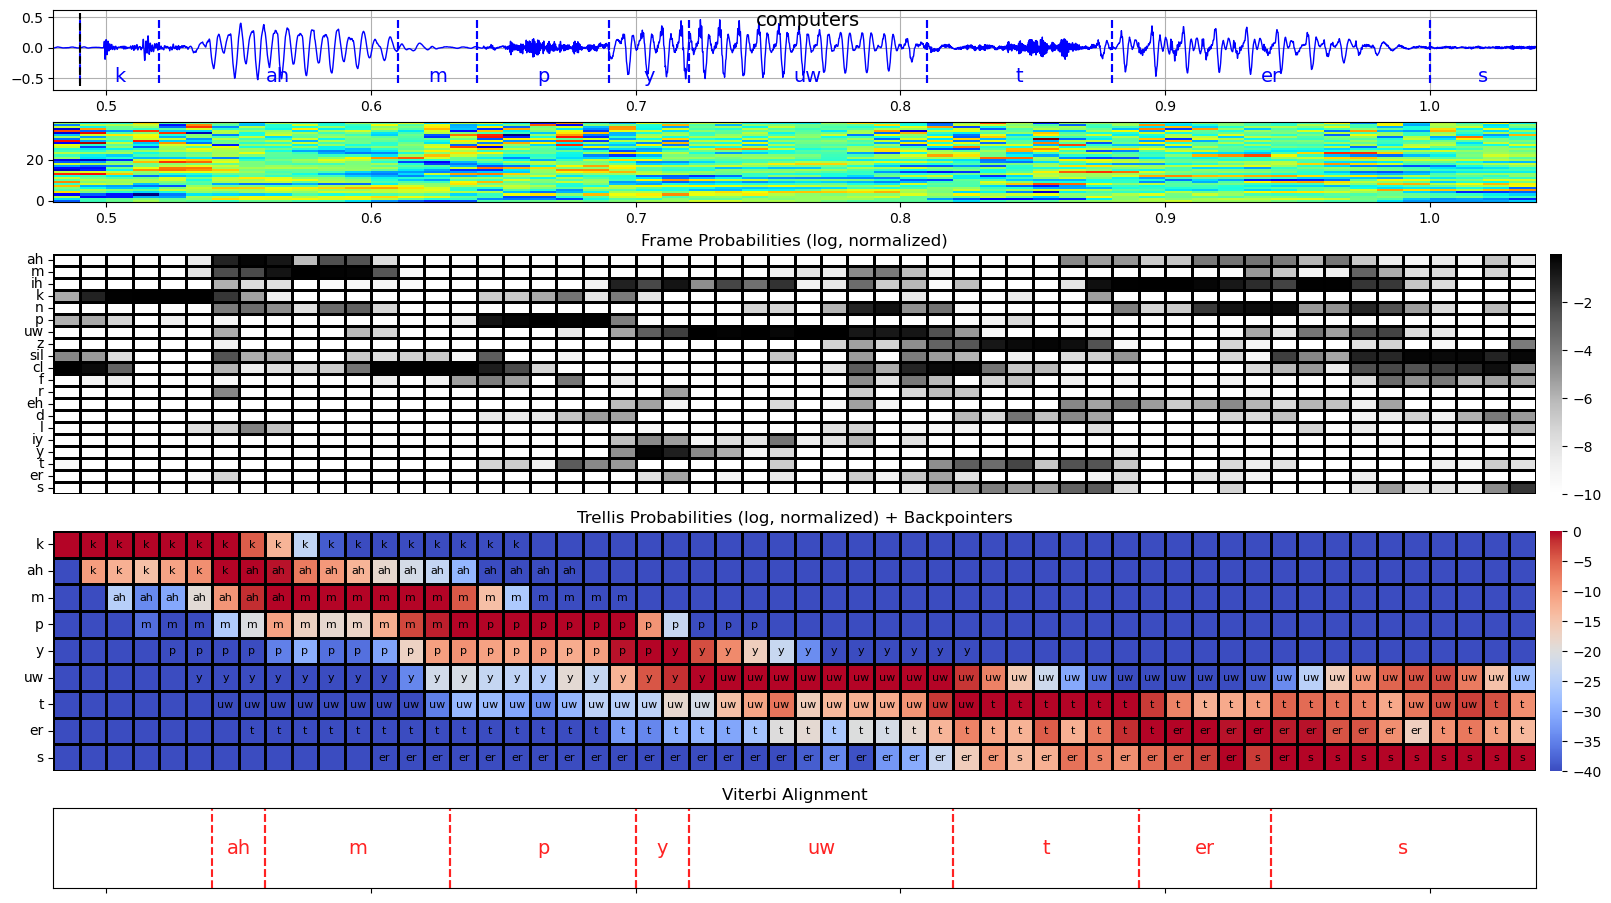

In [46]:
#
ANNOT =  "BACKPTRS" # must be BACKPTRS, VALUES or None
#ANNOT = "VALUES"
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,3,1],frames=frames,
            sample_rate=sr, figsize=(16,9), img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftrs, iax_prob,  iax_trel, iax_vit ) = (0,1,2,3,4)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='b',size=14) 
fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
#
log_probs = np.log(frame_proba) 
plot_probs(log_probs[frame_slice,indx_sel],phn_sel,fig=fig, cmap='Greys',iax=iax_prob,title="Frame Probabilities (log, normalized)",
          vmin=-10, style="img" ) # style="lin",yrange=[.,0]  )
#
trel_probs = trellis1.probs
bp_labels = make_bplabels(trellis1.backptrs,phone_seq)
if ANNOT is None:    kwargs = {}
elif ANNOT == "BACKPTRS": kwargs = { 'annot' : bp_labels.T, 'annot_kws':{'fontsize':8,'color':'k'}, 'fmt':'' }
elif ANNOT == "VALUES": kwargs = { 'annot' : True, 'fmt':'.0f' }
plot_probs(trellis1.probs,fig=fig,cmap='coolwarm',labels=phone_seq,iax=iax_trel,title="Trellis Probabilities (log, normalized) + Backpointers",
          style="img",vmin=-40,**kwargs) 
fig.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.5,color='#F22',size=14,title="Viterbi Alignment")
display(fig)

In [48]:
y_vit_lbl

array(['k', 'k', 'k', 'k', 'k', 'k', 'ah', 'ah', 'm', 'm', 'm', 'm', 'm',
       'm', 'm', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'y', 'y', 'uw', 'uw',
       'uw', 'uw', 'uw', 'uw', 'uw', 'uw', 'uw', 'uw', 't', 't', 't', 't',
       't', 't', 't', 'er', 'er', 'er', 'er', 'er', 's', 's', 's', 's',
       's', 's', 's', 's', 's', 's'], dtype='<U2')

### Print detailed values in the last columns

In [15]:
pd.set_option('display.float_format', '{:.1f}'.format)
nfr = log_probs.shape[0]
i1 = nfr-15
i2 = nfr
df_obs = pd.DataFrame(log_probs[i1:i2,indx_sel].T,index=phn_sel,columns=np.arange(i1,i2))
df_trel = pd.DataFrame(trel_probs[i1:i2,:].T,index=phone_seq,columns=np.arange(i1,i2))
df_bptr = pd.DataFrame(bp_labels[i1:i2,:].T,index=phone_seq,columns=np.arange(i1,i2))
print("OBSERVATION PROBABILITIES (log)")
display(df_obs)
print("TRELLIS PROBABILITIES (log, normalized)")
display(df_trel)
print("BACKPOINTERS")
display(df_bptr)

ValueError: Shape of passed values is (11, 0), indices imply (11, 15)

## QUESTIONS

These questions relate to "EXERCISE2".   
Always assume that SILENCE at the end is optional as your end point detector used to generate the fragment may be cutting into the final parts of speech  

- What word did the system recognize at the end of the recording ?
- What word did you recognize if the recording was terminated at frame 44 ?
- Did you recognize SILENCE at the end in either of the above cases ?